# Stacking moorings

Features developed:
1. Multiple instrument types per mooring
1. Multiple variables per mooring
1. Stack timeseries

Issues:
1. I had z_nom, lat_nom, lon_nom as attributes before. I now get that should have been actual nc coordinates. 

In [1]:

import pIMOS.xrwrap.seabird_37_39_56 as wrap_sbd
import pIMOS.xrwrap.wetlabs_ntu as wetlabs_ntu
import pIMOS.xrwrap.nortek_signature as nortek_signature
import pIMOS.xrwrap.nortek_vector as nortek_vector #, num2date_lk

import os
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import numpy as np 
import pandas as pd
import glob

import pIMOS.utils.quality_control as pqc
import importlib
import zutils.time as ztime

from zutils.xrwrap import xrwrap

# O Drive is //drive.irds.uwa.edu.au/CEME-BBL-001
# pIMOS_export_dir = r'O:\Data\pIMOS\KISSME'

project_root = r'G:\Experiments\kissme17'
project_root = r'E:\Experiments\kissme17'

archive_dir = os.path.join(project_root, 'archive_FV01') 
dbconfig_file = os.path.join(project_root, 'database', 'config.txt') 

if not os.path.exists(archive_dir):
    os.mkdir(archive_dir)
    

<class 'datetime.datetime'>
Module tested
<class 'datetime.datetime'>
Time vector is well spaced
<class 'numpy.datetime64'>
Time vector is well spaced
There are 101 elements in this 10 second period spaced at 0.1.
Time Module OK
[[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
Time vector is well spaced
Time vector is well spaced
There are 101 elements in this 10 second period spaced at 0.1.
Time Module OK


c:\users\azulberti\dropbox\university\phd\03_code\source_code\turbo_tools\turbo_tools\utils\time.py:182: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ans = linspacetime(pd.datetime.today(), pd.datetime.today()+datetime.timedelta(1), n=100)
c:\users\azulberti\dropbox\university\phd\03_code\source_code\turbo_tools\turbo_tools\utils\time.py:189: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ans = linspacetime(pd.datetime.today(), pd.datetime.today()+dt, dt_s=dt_s)
c:\users\azulberti\dropbox\university\phd\03_code\source_code\zutils\zutils\time.py:217: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ans = linspacetime(pd.datetime.today(), pd.datetime.today()+datetime.timedelta(1), n=100)
c:\us

In [2]:

# # if True:
# def stack(mooring, stack_variables, instruments, **kwargs):
#     """
#     kwargs:
#         dt_sec: timestep of the stacked mooring in seconds [default=60]
#         start: datatime.datetime for the start of the stacked file [default is start of first file]
#         end: datatime.datetime for the end of the stacked file [default is end of first file]
#     """
    
#     dt_sec = kwargs.pop('dt_sec', 60)
#     start = kwargs.pop('start', None)
#     end = kwargs.pop('end', None)
    
#     stacked = {}
    
#     files = []
#     for instrument in instruments:
#         instr_dir = os.path.join(archive_dir, instrument) 
#         files += glob.glob(instr_dir+'/*KISSME2017*KISSME_REC*{}*.nc'.format(mooring))
    
#     assert(type(dt_sec)==int)
#     assert(type(seconds_back)==int)
    
#     for i, file in enumerate(files):

#         print('Loading file {} of {}'.format(i, len(files)))
#         rr, ds = wrap_sbd.from_netcdf(file)    
        
#         ref_time = ds.time.values[0]
#         time_secs = ztime.seconds_since(ds.time.values, ref_time)
        
#         if i==0:
#             # Initialise the time array. For now it will be clipped to the first file. 

#             dt_file = ds.time.values[1] - ds.time.values[0]

#             if start is None:
#                 start_sec = 0
#             else:
#                 start = np.datetime64(start)
#                 start_sec = ztime.seconds_since(start, ref_time)
                
#             if end is None:
#                 end_sec = time_secs[-1]
#             else:
#                 end = np.datetime64(end)
#                 end_sec = ztime.seconds_since(end, ref_time)
                
#             time_stacked = np.arange(start_sec, end_sec, dt_sec)

#         for stack_variable in stack_variables:
            
#             if stack_variable in rr.ds.data_vars.keys():
#                 var = rr.get_qaqc_var(stack_variable)
#                 var_interp = np.interp(time_stacked, time_secs, var)
#             else:
#                 # Just nans if the var doesn't exist
#                 var_interp = np.nan*np.zeros(time_stacked.shape)
                
#             if i==0:
#                 stacked[stack_variable] = var_interp
#             else:
#                 stacked[stack_variable] = np.vstack([stacked[stack_variable], var_interp])

#         z_here = ds.attrs['nominal_site_depth'] + ds.attrs['nominal_instrument_height_asb']
#         if i==0:
#              z_stacked = [z_here]
#         else:
#              z_stacked += [z_here]
            
# #     make_time array
    
#     stacked['time'] = np.array([ref_time + np.timedelta64(int(i), 's') for i in time_stacked])

#     z_stacked = np.array(z_stacked)
#     ai = np.argsort(z_stacked)
#     z_stacked = z_stacked[ai]
#     stacked['z'] = z_stacked

#     for stack_variable in stack_variables:

#         stacked[stack_variable] = stacked[stack_variable][ai, :]

#         print(stack_variable)
        
#     return stacked


In [231]:
from collections import OrderedDict

def stack_prof(mooring, stack_variables, instruments, **kwargs):
    """
    NOTES: 
        - Interpolation is by neqarest neighbour. A large reduction in timestep won't result in any kind of filter.
        - The first and last values of any record are set to np.nan to prevent extrap
    
    kwargs:
        dt_sec: timestep of the stacked mooring in seconds [default=60]
        start: datatime.datetime for the start of the stacked file [default is start of first file]
        end: datatime.datetime for the end of the stacked file [default is end of first file]
        z_method: variable name used as z_coordinate in stacking [default is None in which case it tries to use file attrs]
    """
    
    dt_sec = kwargs.pop('dt_sec', 60)
    start = kwargs.pop('start', None)
    end = kwargs.pop('end', None)
    z_method = kwargs.pop('z_method', 'z_nom')
    
    stacked = {}
    
    # Used later on in validation
    first_dimension_set = None
    
    files = []
    for instrument in instruments:
        instr_dir = os.path.join(archive_dir, instrument) 
        files += glob.glob(instr_dir+'/*KISSME2017*KISSME_REC*{}*.nc'.format(mooring))
    
    assert(type(dt_sec)==int)
    
    for i, file in enumerate(files):

        print('Loading file {} of {}'.format(i, len(files)))
        if False:
            rr, ds = wrap_sbd.from_netcdf(file)    
        else:
            ds = xr.open_dataset(file)
            rr = xrwrap()
            rr.wrap(ds)
        
        if i==0: # Just do this once. Don't need to do it at all actually
            ref_time = ds.time.values[0]
            
        print('    File starts {}'.format(ds.time.values[0]))
        time_secs = ztime.seconds_since(ds.time.values, ref_time)
        
        z_source_here = [ds.attrs['instrument_model'] + ' ' +  str(ds.attrs['instrument_serial_number'])]
        
        if i==0:
            # Initialise the time array. For now it will be clipped to the first file. 

            dt_file = ds.time.values[1] - ds.time.values[0]

            if start is None:
                start_sec = 0
            else:
                start = np.datetime64(start)
                start_sec = ztime.seconds_since(start, ref_time)
                
            if end is None:
                end_sec = time_secs[-1]
            else:
                end = np.datetime64(end)
                end_sec = ztime.seconds_since(end, ref_time)
                
            time_stacked = np.arange(start_sec, end_sec, dt_sec)

        for stack_variable in stack_variables:
            
            if stack_variable in rr.ds.data_vars.keys():
                var = rr.get_qaqc_var(stack_variable)
                var_values = var.values
                # Some validation
                if var.dims == ('distance', 'time'):
                    pass
                elif var.dims == ('time',):
                    var_values = var_values[None, :] # To make the interpolation syntax consistent for profiles and timeseries
                else:
                    print(var.dims)
                    raise(Exception('Yeahhhhhhhh nahhhhhh!!! This stacking tool has only been cobbled together for certian use cases. And unfortunately yours is not one. I recommend hacking up this code to make your own merge function'))

                # Some more validation 
                if first_dimension_set is None: # This will be None on the first pass
                    first_dimension_set = var.dims
                elif not var.dims == first_dimension_set:
                    raise(Exception("The set of variables you are trying to merge don't have trhe same dimensions. This won't work."))
                
                # KILL FIRST AND LAST VALUE
                var_values[:, 0] = np.nan
                var_values[:, -1] = np.nan
                
                # WARNING - THIS JUST DOES A NEAREST INTERP. THIS IS NOT A FILTER OR MOVING AVERAGE
                var_interp = np.array([np.interp(time_stacked, time_secs, var_row) for var_row in var_values])
                
            else:
                # Just nans if the var doesn't exist
                var_interp = np.nan*np.zeros(time_stacked.shape)
                
            if i==0:
                stacked[stack_variable] = var_interp
            else:
                stacked[stack_variable] = np.vstack([stacked[stack_variable], var_interp])


        if z_method is None:
            raise(Exception)
            z_here = ds.attrs['nominal_site_depth'] + ds.attrs['nominal_instrument_height_asb']
            z_here = np.array([z_here])[:, None]
        else:
            z_here = ds[z_method].values
            if z_here.shape==(): # If zero dimensional make one dimensional
                z_here = z_here[None] # 
            z_here = z_here[:, None] # Now make two dimensional
            
        if i==0:
            z_stacked = z_here
        else:
#             return z_stacked, z_here
            z_stacked = np.vstack([z_stacked, z_here])
            
        z_source_here = z_source_here*len(z_here)
        if i==0:
            z_source = z_source_here
        else:
            z_source += z_source_here
    
    # Make a dictionary
    stacked['time'] = np.array([ref_time + np.timedelta64(int(i), 's') for i in time_stacked])
    z_stacked = z_stacked.flatten()
    ai = np.argsort(z_stacked, axis=0)
    z_stacked = z_stacked[ai]
    stacked['z'] = z_stacked
    stacked['ai'] = ai

    for stack_variable in stack_variables:

        stacked[stack_variable] = stacked[stack_variable][ai, :]
        
    # Make an xr DataSet
    ds_stacked = xr.Dataset(attrs={})
    encoding = {}
    coords = OrderedDict()
    coords.update({z_method: z_stacked})
    coords.update({'time': stacked['time']})
    
    for stack_variable in stack_variables:
        
        V = xr.DataArray( stacked[stack_variable],\
            dims=coords,\
            name=var,\
            attrs = {},\
            coords = coords
        )

        ds_stacked.update({stack_variable:V})
        
        encoding.update({stack_variable:{'zlib':True,'_FillValue':-999999.}})
        
    z_source = np.array(z_source)[ai]
    V = xr.DataArray( z_source,\
            dims={z_method: z_stacked},\
            name='source',\
            attrs = {},\
            coords = {z_method: z_stacked}
        )
    ds_stacked.update({'source':V})
    
#     return stacked, ds_stacked
    return ds_stacked, ds



In [243]:
sbds = ['SBE56', 'SBE39', 'SBE37']

mooring = 'SP250'
start = datetime.datetime(2017, 3, 31)
end = datetime.datetime(2017, 5, 1)
ds_scalar_sp250, ds = stack_prof(mooring, 
                     ['Temperature', 'Pressure'], 
                     sbds, 
                     start=start, 
                     end=end,
                     z_method='z_nom')

mooring = 'NP250'
ds_scalar_np250, ds = stack_prof(mooring, 
                     ['Temperature', 'Conductivity', 'Pressure'], 
                     sbds, 
                     start=start, 
                     end=end,
                     z_method='z_nom')

mooring = 'WP250'
ds_scalar_wp250, ds = stack_prof(mooring, 
                     ['Temperature', 'Pressure'], 
                     sbds, 
                     start=start, 
                     end=end,
                     z_method='z_nom')


Loading file 0 of 45
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 57602 values.
Loading file 1 of 45
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 57602 values.
Loading file 2 of 45
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 57602 values.
Loading file 3 of 45
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 138244 values.
Loading file 4 of 45
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 57602 values.
Loading file 5 of 45
Wrapped an existing xarray d

Loading file 0 of 26
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 230460 values.
Loading file 1 of 26
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 230402 values.
Loading file 2 of 26
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 230524 values.
Loading file 3 of 26
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 230475 values.
Loading file 4 of 26
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 230456 values.
Loading file 5 of 26
Wrapped an existing xarr

Loading file 22 of 24
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 39198 values.
Loading file 23 of 24
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
    File starts 2017-04-01T01:00:00.000000000
Blanking 40439 values.


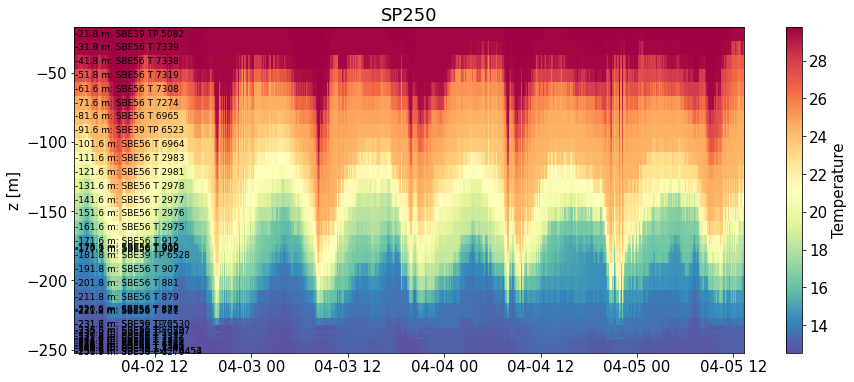

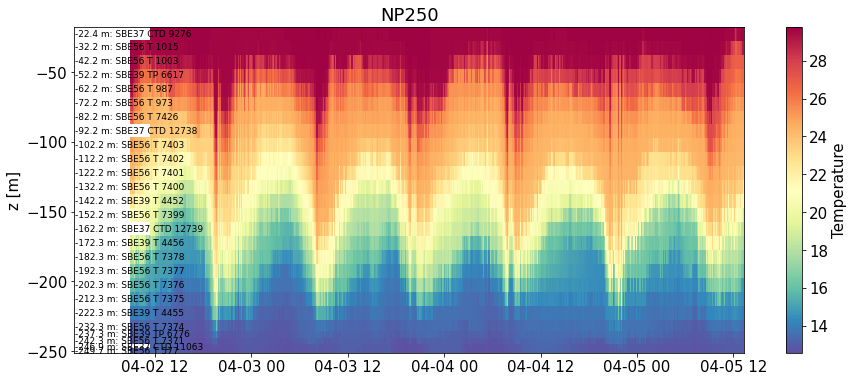

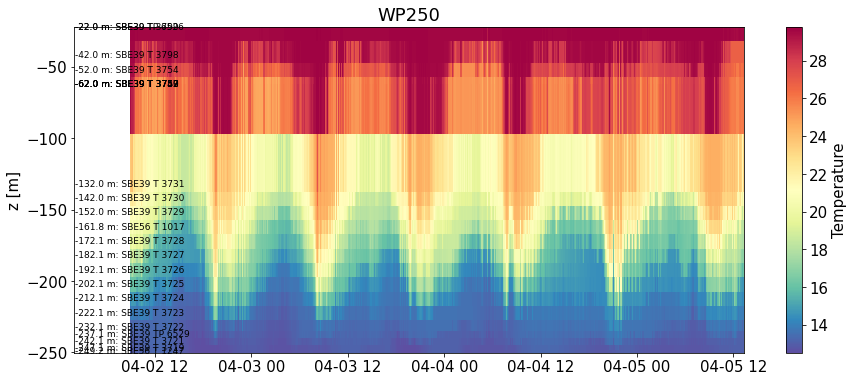

In [244]:
tind = np.arange(3000, 8000)

def scalar_plotter(ds, mooring):
    plt.figure(figsize=(15, 6))
    
    plt.pcolor(ds.time[tind], ds.z_nom, ds.Temperature[:, tind], cmap='Spectral_r', shading='auto')
    plt.colorbar(label='Temperature')
    plt.ylabel('z [m]')
    plt.title(mooring)
    [plt.text(ds.time.values[tind][0], 
              ds.z_nom.values[n], 
              '{:.1f} m: {}'.format(ds.z_nom.values[n], ds.source.values[n]), 
              va = 'center',
              fontsize=9) for n in range(len(ds.source.values))]


scalar_plotter(ds_scalar_sp250, 'SP250')
scalar_plotter(ds_scalar_np250, 'NP250')
scalar_plotter(ds_scalar_wp250, 'WP250')

(20.0, 60.0)

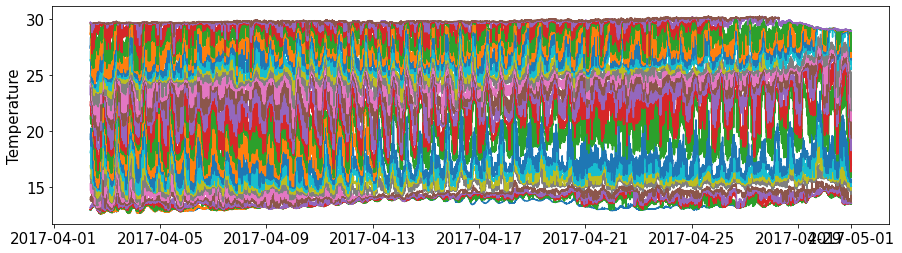

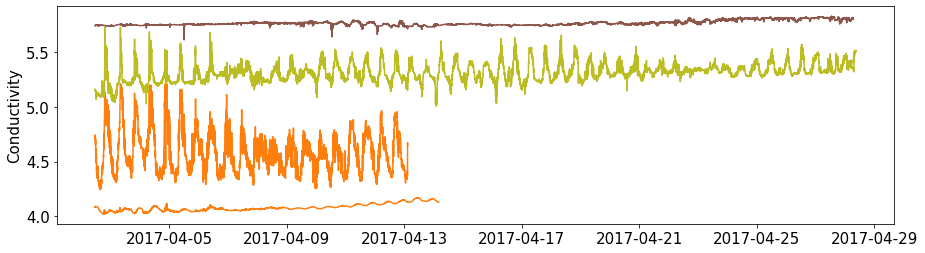

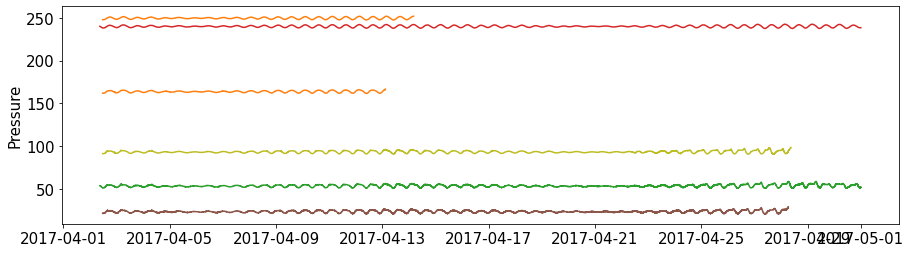

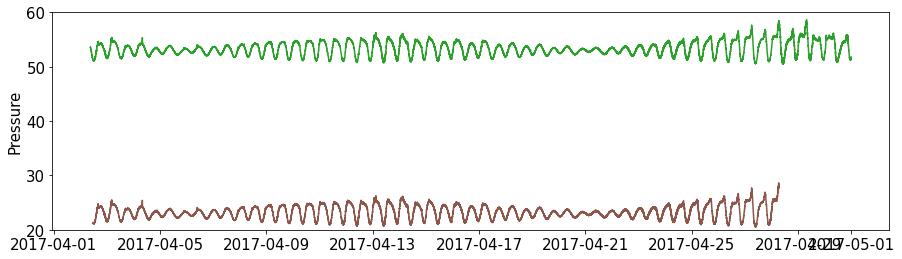

In [237]:
s = 3600

plt.figure(figsize=(15, 4))
plt.plot(ds_scalar_np250.time[s::], ds_scalar_np250.Temperature[:, s::].T)
plt.ylabel('Temperature')

plt.figure(figsize=(15, 4))
plt.plot(ds_scalar_np250.time[s::], ds_scalar_np250.Conductivity[:, s::].T)
plt.ylabel('Conductivity')

plt.figure(figsize=(15, 4))
plt.plot(ds_scalar_np250.time[s::], ds_scalar_np250.Pressure[:, s::].T)
plt.ylabel('Pressure')

plt.figure(figsize=(15, 4))
plt.plot(ds_scalar_np250.time[s::], ds_scalar_np250.Pressure[:, s::].T)
plt.ylabel('Pressure')
plt.ylim([20, 60])

# ^^ Some strange stuff in those pressure plots at the end there

In [103]:

mooring = 'NP250'
start = datetime.datetime(2017, 3, 31)
end = datetime.datetime(2017, 5, 1)
adcps = ['RDI 300 kHz Monitor', 
         'RDI 150 kHz Quartermaster', 
         'RDI 300 kHz Sentinel',
         'RDI75 kHz Longranger'
        ]

ds_vel_np250, bo = stack_prof(mooring, 
                     ['u'], 
                     adcps, 
                     start=start, 
                     end=end,
                     z_method='prof_z_nom')

mooring = 'WP250'
ds_vel_wp250, ds = stack_prof(mooring, 
                     ['u'], 
                     adcps, 
                     start=start, 
                     end=end,
                     z_method='prof_z_nom')

mooring = 'SP250'
ds_vel_sp250, ds = stack_prof(mooring, 
                     ['u'], 
                     adcps, 
                     start=start, 
                     end=end,
                     z_method='prof_z_nom')


Loading file 0 of 2
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
Blanking 112011 values.
<xarray.DataArray 'u' (distance: 46, time: 52820)>
array([[        nan,         nan,         nan, ..., -0.20268934,
        -0.19452215, -0.18389933],
       [        nan,         nan,         nan, ..., -0.18550206,
        -0.17481685, -0.2103163 ],
       [        nan,         nan,         nan, ..., -0.16825248,
        -0.1762776 , -0.19586103],
       ...,
       [        nan,         nan,         nan, ..., -0.29080502,
        -0.31137878, -0.24673712],
       [        nan,         nan,         nan, ..., -0.27726829,
        -0.28596684, -0.30618574],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * distance    (distance) float64 4.2 6.2 8.2 10.2 12.2 ... 88.2 90.2 92.2 94.2
  * time        (time) datetime64[ns] 2017-03-31T23:00:00.000003 ... 2017-05-...
    lat_nom     f

[-244.4  -242.4  -240.4  -238.4  -236.4  -234.4  -232.4  -230.4  -228.4
 -226.4  -224.4  -222.4  -220.4  -218.4  -216.4  -214.4  -212.4  -210.4
 -208.4  -206.4  -204.4  -202.4  -200.4  -198.4  -196.4  -194.4  -192.4
 -190.4  -188.4  -186.4  -184.4  -182.4  -180.4  -178.4  -176.4  -174.4
 -172.4  -170.4  -168.4  -166.4  -164.4  -162.4  -160.4  -159.64 -158.4
 -156.4  -155.64 -154.4  -151.64 -147.64 -143.64 -139.64 -135.64 -131.64
 -127.64 -123.64 -119.64 -115.64 -111.64 -107.64 -103.64  -99.64  -95.64
  -91.64  -87.64  -83.64  -79.64  -75.64  -71.64  -67.64  -63.64  -59.64
  -55.64  -51.64  -47.64  -43.64  -39.64  -35.64  -31.64  -27.64  -23.64
  -19.64  -15.64  -11.64   -7.64   -3.64    0.36    4.36    8.36   12.36
   16.36]
Loading file 0 of 2
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
Blanking 129253 values.
<xarray.DataArray 'u' (distance: 45, time: 47791)>
array([[        nan,         nan,         nan, ...,  0.01861667,
     

[-248.68 -244.68 -240.68 -236.68 -232.68 -228.68 -224.68 -220.68 -216.68
 -212.68 -208.68 -204.68 -200.68 -196.68 -192.68 -188.68 -184.68 -180.68
 -176.68 -172.68 -168.68 -152.31 -148.31 -144.31 -140.31 -136.31 -132.31
 -128.31 -124.31 -120.31 -116.31 -112.31 -108.31 -104.31 -100.31  -96.31
  -92.31  -88.31  -84.31  -80.31  -76.31  -72.31  -68.31  -64.31  -60.31
  -56.31  -52.31  -48.31  -44.31  -40.31  -36.31  -32.31  -28.31  -24.31
  -20.31  -16.31  -12.31   -8.31   -4.31   -0.31    3.69    7.69   11.69
   15.69   19.69   23.69]
Loading file 0 of 1
Wrapped an existing xarray dataset. Class attributes taken from the dataset. Dataset attrs cleared.
Blanking 280616 values.
<xarray.DataArray 'u' (distance: 63, time: 72457)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan

In [241]:
def ADCP_plotter(ds, mooring, sk=10):
    
    plt.figure(figsize=(15, 4))
    plt.pcolor(ds.time[tind], ds.prof_z_nom, ds.u[:, tind], cmap='RdBu_r', vmin=-0.8, vmax=0.8, shading='auto')
    plt.colorbar(label='u [m/s]')
    plt.ylabel('z [m]')
    plt.title(mooring)
    [plt.text(ds.time.values[tind][0], 
              ds.prof_z_nom.values[n], 
              '{:.1f} m: {}'.format(ds.prof_z_nom.values[n], ds.source.values[n]), 
              va = 'center',
              fontsize=9) for n in np.arange(0, len(ds.source.values), sk)]
    

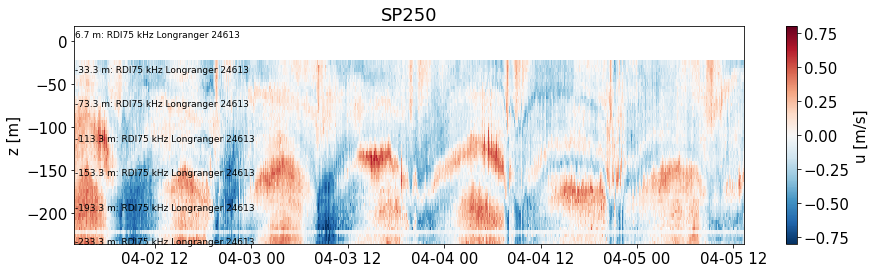

In [245]:
ADCP_plotter(ds_vel_sp250, 'SP250', sk=10)

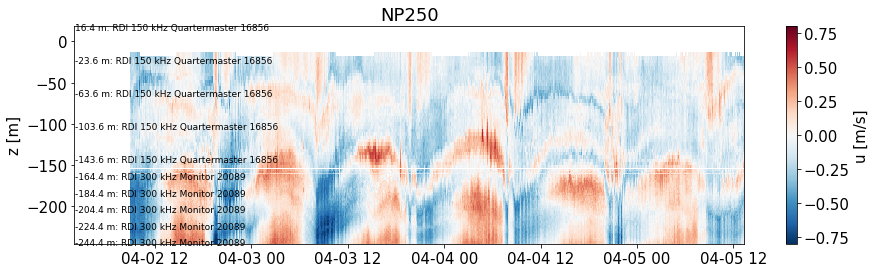

In [246]:
ADCP_plotter(ds_vel_np250, 'NP250', sk=10)

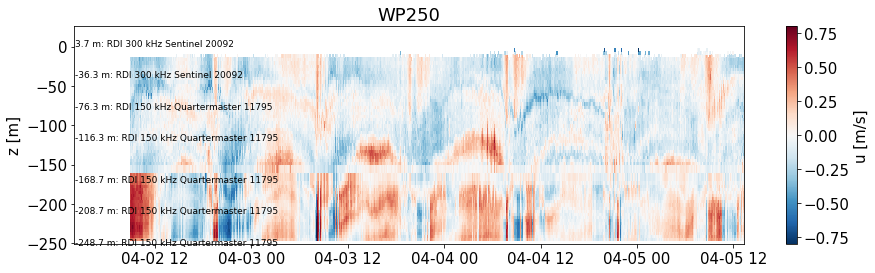

In [247]:
ADCP_plotter(ds_vel_wp250, 'WP250', sk=10)

# ^^ Those WP250 currents look a bit rough! 